In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [2]:
# Membaca file CSV
df = pd.read_csv('data_harga_beras.csv')
# Mengonversi kolom 'Date' menjadi tipe data datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').interpolate(method='linear').reset_index()

# Menampilkan dataframe
df

,Date,C4Super,C4Medium,Bulog
0,2021-01-04,11750.0,10667.000000,9083.0
1,2021-01-05,11750.0,10667.000000,9083.0
2,2021-01-06,11750.0,10667.000000,9083.0
3,2021-01-07,11750.0,10667.000000,9083.0
4,2021-01-08,11750.0,10667.000000,9083.0
...,...,...,...,...
1208,2024-04-26,16167.0,14667.000000,11000.0
1209,2024-04-27,15889.0,14444.666667,11000.0
1210,2024-04-28,15611.0,14222.333333,11000.0
1211,2024-04-29,15333.0,14000.000000,11000.0


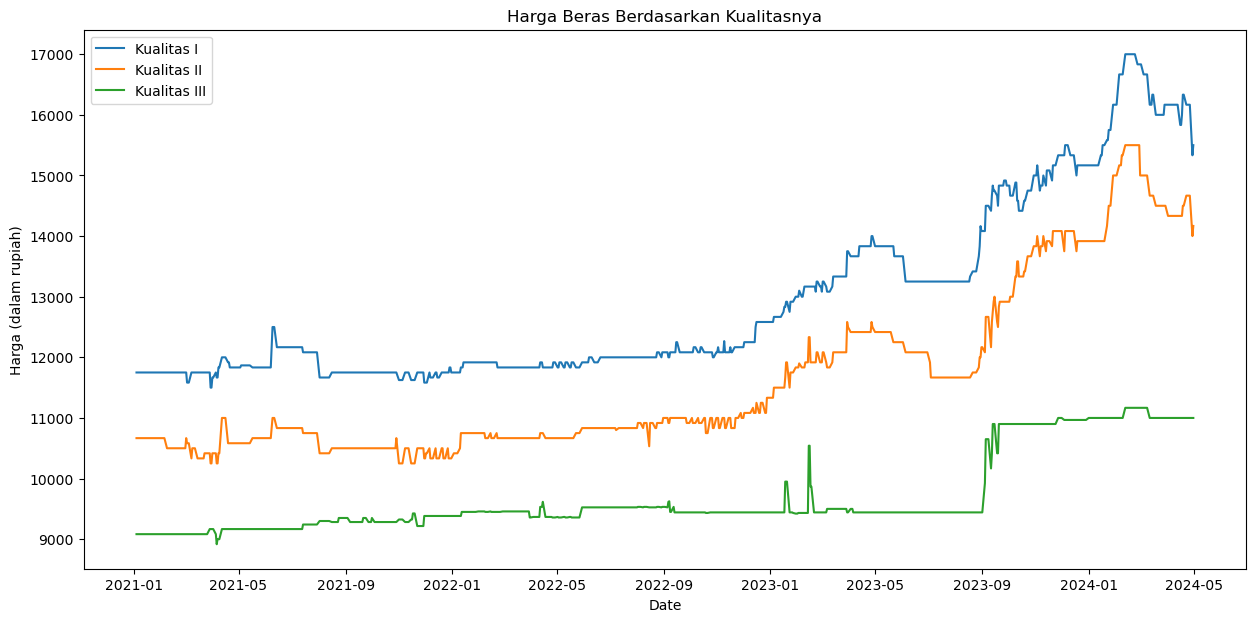

In [3]:
plt.figure(figsize=(15,7))
plt.plot(df['Date'], df['C4Super'], label='Kualitas I')
plt.plot(df['Date'], df['C4Medium'], label='Kualitas II')
plt.plot(df['Date'], df['Bulog'], label='Kualitas III')

# Menambahkan label untuk sumbu x, sumbu y, dan judul grafik
plt.xlabel('Date')
plt.ylabel('Harga (dalam rupiah)')
plt.title('Harga Beras Berdasarkan Kualitasnya')
# Menampilkan legenda
plt.legend()

# Menampilkan grafik
plt.show()

In [4]:
#Menampilkan informasi tentang DataFrame `df`
df.info()

# Menampilkan statistik deskriptif dari DataFrame `df`
df.describe()

# Memeriksa jumlah nilai null (missing values) dalam setiap kolom 
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1213 non-null   datetime64[ns]
 1   C4Super   1213 non-null   float64       
 2   C4Medium  1213 non-null   float64       
 3   Bulog     1213 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 38.0 KB


Date        0
C4Super     0
C4Medium    0
Bulog       0
dtype: int64

In [5]:
# Menetapkan random seed
tf.random.set_seed(123)

In [6]:
# Melakukan drop pada kolom 'C4 Medium' dan 'Bulog'
df = df.drop(['C4Super', 'C4Medium'], axis=1)

In [7]:
# Mengambil nilai dari kolom 'C4Super', mengonversinya menjadi array, dan mengubah tipe data menjadi float32
df = df.filter(['Bulog'])
df = df.values
df = df.astype('float32')

In [8]:
# Normalisasi dataset dengan MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print(df)


[[0.07377791]
 [0.07377791]
 [0.07377791]
 ...
 [0.9257777 ]
 [0.9257777 ]
 [0.9257777 ]]


In [9]:
# Membagi dataset menjadi data latih dan data uji
n_samples = len(df)
train_size = int(n_samples * 0.9)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [10]:
# Time series windowing
def prepare_data(df, timesteps):
    X = []
    Y = []
    for i in range(len(df)-timesteps-1):
        X.append(df[i:(i+timesteps)])
        Y.append(df[i + timesteps, 0])  # Hanya kolom 'Bulog' yang menjadi target
    return np.array(X), np.array(Y)

# Menentukan jumlah time steps (hari) yang digunakan untuk memprediksi harga beras berikutnya
timesteps = 1

# Persiapkan input dan output
X_train, Y_train = prepare_data(train_data, timesteps)
X_test, Y_test = prepare_data(test_data, timesteps)

In [11]:
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print('Train Shape = {0}'.format(X_train.shape))
print('Test Shape = {0}'.format(X_test.shape))


Train Shape = (1089, 1, 1)
Test Shape = (120, 1, 1)


In [12]:
# Inisiasi Hyperparameter
num_neuron = 10
num_epoch = 150
num_batch = 16
adam_optimizer = Adam(learning_rate=0.001)

# Membuat model LSTM
model = Sequential()
model.add(LSTM(4, activation='tanh', recurrent_activation='sigmoid', 
               return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(num_neuron, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, bias_initializer='zeros'))

model.summary()

# Build model and compile
model.compile(optimizer=adam_optimizer, loss='mse', metrics=['MAPE'])

# Melatih model dengan menggunakan set data Training
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epoch, batch_size=num_batch, verbose=1)

C:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 4)           │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707 (2.76 KB)

 Trainable params: 707 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - MAPE: 51014.2461 - loss: 0.1103 - val_MAPE: 83.3654 - val_loss: 0.6193
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 153308.6719 - loss: 0.0589 - val_MAPE: 68.6372 - val_loss: 0.4202
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 203305.6719 - loss: 0.0470 - val_MAPE: 61.5926 - val_loss: 0.3384
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 203865.5000 - loss: 0.0385 - val_MAPE: 53.3921 - val_loss: 0.2543
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 148896.7188 - loss: 0.0285 - val_MAPE: 40.1217 - val_loss: 0.1436
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAPE: 127906.6250 - loss: 0.0175 - val_MAPE: 23.5127 - val_loss: 0.0493
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - MAPE: 114055.3359 - loss: 0.0114 - val_MAPE: 10.6768 - val_loss: 0.0102
Epoch 8/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MAPE: 74269.6328 - loss: 0.0087 - val_MAPE: 12.6549 - val_loss: 0.

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAPE: 48999.8750 - loss: 0.0051 - val_MAPE: 6.0909 - val_loss: 0.0034
Epoch 53/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAPE: 1046.2618 - loss: 0.0047 - val_MAPE: 8.0826 - val_loss: 0.0059
Epoch 54/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 98065.5938 - loss: 0.0050 - val_MAPE: 9.5299 - val_loss: 0.0082
Epoch 55/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MAPE: 6186.7417 - loss: 0.0064 - val_MAPE: 7.4316 - val_loss: 0.0050
Epoch 56/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - MAPE: 67517.6797 - loss: 0.0041 - val_MAPE: 3.6716 - val_loss: 0.0013
Epoch 57/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - MAPE: 30233.8613 - loss: 0.0056 - val_MAPE: 4.4096 - val_loss: 0.0018
Epoch 58/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAPE: 32244.0762 - loss: 0.0049 - val_MAPE: 4.7609 - val_loss: 0.0021
Epoch 59/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAPE: 162305.2344 - loss: 0.0041 - val_MAPE: 6.5228 - val_loss: 0.0039
Epoch 60/150
69/6

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAPE: 16901.8398 - loss: 0.0050 - val_MAPE: 7.5761 - val_loss: 0.0055
Epoch 104/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 21196.0586 - loss: 0.0031 - val_MAPE: 7.3627 - val_loss: 0.0052
Epoch 105/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MAPE: 85188.9688 - loss: 0.0044 - val_MAPE: 6.4534 - val_loss: 0.0041
Epoch 106/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAPE: 78947.9922 - loss: 0.0043 - val_MAPE: 5.8135 - val_loss: 0.0034
Epoch 107/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAPE: 78330.9688 - loss: 0.0041 - val_MAPE: 5.8973 - val_loss: 0.0035
Epoch 108/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - MAPE: 53232.9961 - loss: 0.0037 - val_MAPE: 6.9641 - val_loss: 0.0047
Epoch 109/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAPE: 105941.7891 - loss: 0.0047 - val_MAPE: 5.7352 - val_loss: 0.0033
Epoch 110/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAPE: 61324.1523 - loss: 0.0036 - val_MAPE: 7.6091 - val_loss: 0.0056
Epoch 1

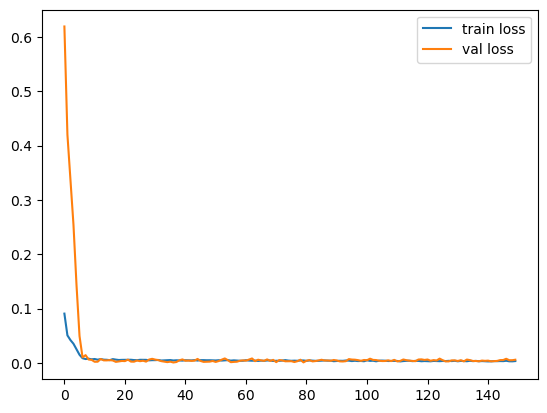

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [14]:
# Predicting
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

In [15]:
# Menghitung MAE
mae = mean_absolute_error(Y_test, test_predict)
print('MAE = ', round(mae, 4))

# Hitung RMSE
rmse = sqrt(mean_squared_error(Y_test, test_predict))
print('RMSE = ', round(rmse, 4))

test_mape = model.evaluate(X_test, Y_test)
print(f'Test MAPE: {test_mape[1]}')

MAE =  0.0725
RMSE =  0.0761
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAPE: 7.5713 - loss: 0.0057 
Test MAPE: 7.613956928253174


In [16]:
# Visualisasi data test (aktual) dan data hasil prediksi
plot_predict_test = model.predict(X_test, verbose=0)
plot_predict_train = model.predict(X_train, verbose=0)

print("Train Predictions:")
print(train_predict)

print("\nTest Predictions:")
print(test_predict)

Train Predictions:
[[0.07941532]
 [0.07941532]
 [0.07941532]
 ...
 [0.86157495]
 [0.86157495]
 [0.861575  ]]

Test Predictions:
[[0.864769  ]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.86630344]
 [0.87344587]
 [0.8795895 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.8847924 ]
 [0.

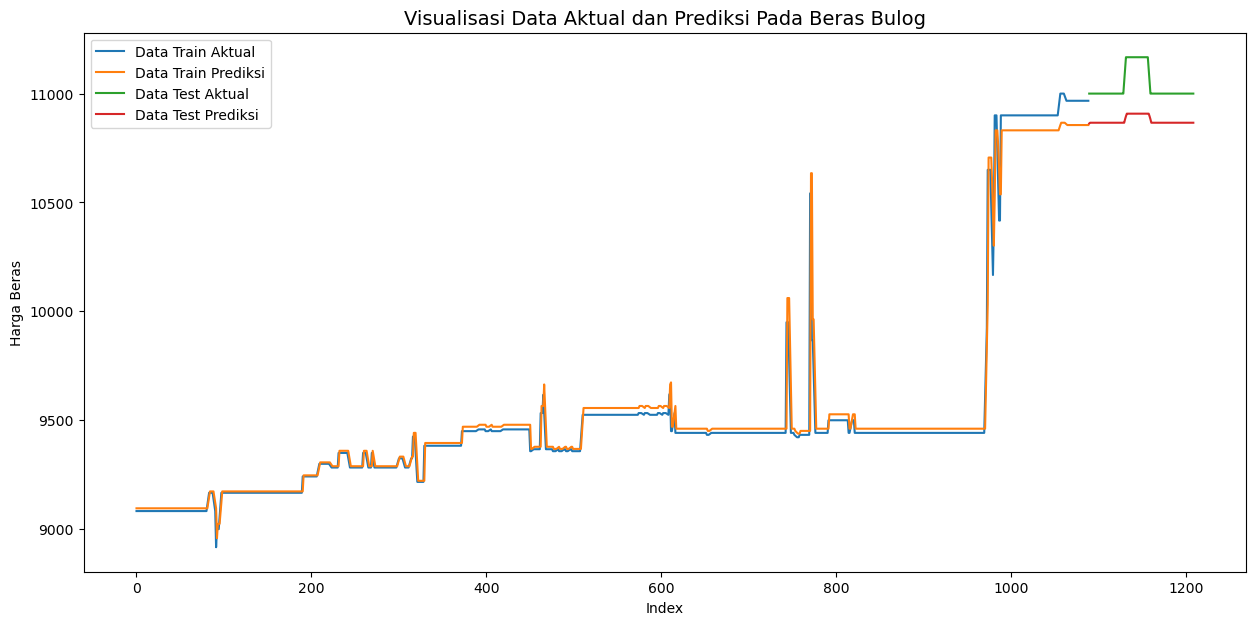

In [17]:
# Inverse transform the predictions and actual values
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 2))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2))), axis=1))[:, 0]
plot_predict_train = scaler.inverse_transform(np.concatenate((plot_predict_train, np.zeros((plot_predict_train.shape[0], 2))), axis=1))[:, 0]
plot_predict_test = scaler.inverse_transform(np.concatenate((plot_predict_test, np.zeros((plot_predict_test.shape[0], 2))), axis=1))[:, 0]

plt.figure(figsize=(15,7))
plt.plot(np.arange(len(Y_train)), Y_train, label='Data Train Aktual')
plt.plot(np.arange(len(Y_train)), plot_predict_train, label='Data Train Prediksi')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Data Test Aktual')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), plot_predict_test, label='Data Test Prediksi')
plt.title('Visualisasi Data Aktual dan Prediksi Pada Beras Bulog', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.legend()
plt.show()


In [18]:
# Menampilkan Data Test dan Prediksi dalam bentuk tabel
results = pd.DataFrame({
    'Data Test': Y_test,
    'Data Predict LSTM': plot_predict_test
})
print(results.head(10))
print(results.tail(10))

      Data Test  Data Predict LSTM
0  10999.999758       10862.730204
1  10999.999758       10866.182743
2  10999.999758       10866.182743
3  10999.999758       10866.182743
4  10999.999758       10866.182743
5  10999.999758       10866.182743
6  10999.999758       10866.182743
7  10999.999758       10866.182743
8  10999.999758       10866.182743
9  10999.999758       10866.182743
        Data Test  Data Predict LSTM
110  10999.999758       10866.182743
111  10999.999758       10866.182743
112  10999.999758       10866.182743
113  10999.999758       10866.182743
114  10999.999758       10866.182743
115  10999.999758       10866.182743
116  10999.999758       10866.182743
117  10999.999758       10866.182743
118  10999.999758       10866.182743
119  10999.999758       10866.182743


In [19]:
# Menghitung nilai MAPE
mape = mean_absolute_percentage_error(Y_test, plot_predict_test) * 100
print('Nilai MAPE = ', round(mape, 4))

Nilai MAPE =  1.474
